# Variance-Aware Smoothing for Survey KPIs

## Overview

This notebook demonstrates a principled approach to smoothing time series survey data that accounts for varying sample sizes and measurement uncertainty across time periods.

### The Problem

Weekly or monthly survey KPIs exhibit noise because each period has finite (and often varying) sample size $n_t$. This sampling error:
- Adds variance without adding information
- Creates noisy dashboards and unstable trends
- Makes period-to-period comparisons difficult

**Key insight:** Not all observations are equally reliable. A month with $n=50$ respondents should be smoothed more than a month with $n=500$.

### Our Approach

We use **Kalman smoothing** with period-specific measurement variance to:
1. Estimate measurement uncertainty for each period based on effective sample size
2. Apply optimal smoothing that adapts to data quality
3. Provide uncertainty bands for the smoothed estimates

### Mathematical Framework

#### Step 1: Weighted Mean and Measurement Variance

For each time period $t$, from individual microdata $(y_{it}, w_{it})$:

**Weighted mean:**
$$\hat{y}_t = \frac{\sum_i w_{it} y_{it}}{\sum_i w_{it}}$$

**Effective sample size** (accounts for unequal weights):
$$n_{\text{eff},t} = \frac{(\sum_i w_{it})^2}{\sum_i w_{it}^2}$$

**Weighted sample variance** (Bessel-corrected):
$$s_{w,t}^2 = \frac{\sum_i w_{it}(y_{it} - \hat{y}_t)^2}{\sum_i w_{it} - \frac{\sum_i w_{it}^2}{\sum_i w_{it}}}$$

**Measurement variance of the mean:**
$$H_t = \text{Var}(\hat{y}_t) \approx \frac{s_{w,t}^2}{n_{\text{eff},t}}$$

This gives us period-specific uncertainty: small $n_{\text{eff},t}$ → large $H_t$ → more smoothing.

#### Step 2: State Space Model (Kalman Filter/Smoother)

We model the true KPI $\mu_t$ as a slowly evolving local level:

**Observation equation:**
$$y_t = \mu_t + \varepsilon_t, \quad \varepsilon_t \sim \mathcal{N}(0, H_t)$$

**State equation:**
$$\mu_t = \mu_{t-1} + \eta_t, \quad \eta_t \sim \mathcal{N}(0, Q)$$

Where:
- $H_t$: measurement variance (from survey sampling, varies by period)
- $Q$: process variance (how much the true signal can change month-to-month)

#### Step 3: Signal-to-Noise Ratio (SNR)

To avoid identifiability issues when both $Q$ and $H$ are unknown, we fix their ratio:

$$\text{SNR} = \frac{Q}{Q + \bar{H}}$$

Where $\bar{H}$ is the average measurement variance. We then estimate only the overall scale $\sigma^2$:
- $Q = \text{SNR} \cdot \sigma^2$
- $H_t = (1 - \text{SNR}) \cdot \sigma^2 \cdot \frac{H_t}{\bar{H}}$ (scaled by relative measurement variance)

**Interpretation:**
- SNR = 0.01 → Very smooth (1% signal, 99% noise)
- SNR = 0.05 → Moderate smoothing (5% signal, 95% noise)
- SNR = 0.10 → Light smoothing (10% signal, 90% noise)

### Data: University of Michigan Index of Consumer Sentiment

We'll use the monthly ICS data which includes:
- Individual response microdata with survey weights
- Published aggregate index values

This is an ideal test case because we can:
1. Calculate weighted means ourselves
2. Estimate measurement variance from effective sample size
3. Apply our smoothing procedure
4. Compare to published values

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.structural import UnobservedComponents
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 1. Load Data from GitHub

We'll load two datasets:
1. **Individual microdata** (`AAk7MRJC.csv`): Individual survey responses with weights
2. **Published aggregate** (`scaum-479.csv`): Official monthly ICS values

In [2]:
# Load individual microdata
url_microdata = "https://raw.githubusercontent.com/oysteinm/smood/refs/heads/main/AAk7MRJC.csv"
ics_microdata = pd.read_csv(url_microdata)

# Convert YYYYMM to datetime
ics_microdata['date'] = pd.to_datetime(ics_microdata['YYYYMM'], format='%Y%m')

# Clean column names (lowercase)
ics_microdata.columns = ics_microdata.columns.str.lower()

print(f"Microdata shape: {ics_microdata.shape}")
print(f"\nColumns: {list(ics_microdata.columns)}")
print(f"\nDate range: {ics_microdata['date'].min()} to {ics_microdata['date'].max()}")
ics_microdata.head()

Microdata shape: (336373, 25)

Columns: ['caseid', 'yyyymm', 'yyyyq', 'yyyy', 'id', 'idprev', 'datepr', 'idprev2', 'datepr2', 'sample', 'method', 'ics', 'icc', 'ice', 'pinc', 'pinc2', 'pjob', 'pssa', 'pcry', 'pstk', 'polaff', 'wt', 'wt_hh', 'wt_quintmed', 'date']

Date range: 1978-01-01 00:00:00 to 2025-09-01 00:00:00


,caseid,yyyymm,yyyyq,yyyy,id,idprev,datepr,idprev2,datepr2,sample,...,pinc2,pjob,pssa,pcry,pstk,polaff,wt,wt_hh,wt_quintmed,date
0,1,197801,19781,1978,1,,,,,1,...,,,,,,,0.00,,,1978-01-01
1,2,197801,19781,1978,2,,,,,1,...,,,,,,,0.72,,,1978-01-01
2,3,197801,19781,1978,3,,,,,1,...,,,,,,,1.03,,,1978-01-01
3,4,197801,19781,1978,4,,,,,1,...,,,,,,,0.00,,,1978-01-01
4,5,197801,19781,1978,5,,,,,1,...,,,,,,,0.93,,,1978-01-01


In [6]:
# Load published aggregate data
url_published = "https://raw.githubusercontent.com/oysteinm/smood/refs/heads/main/ics_month.csv"

# Read and clean potential hidden BOM/whitespace in headers
ics_published = pd.read_csv(url_published)
ics_published.columns = ics_published.columns.str.strip().str.replace('\ufeff', '', regex=True)

# Convert 'yyyymm' to datetime (it’s already in ISO format like 1978-01-01)
ics_published['date'] = pd.to_datetime(ics_published['yyyymm'])

# Keep only what you need
ics_published = ics_published[['date', 'ics_all']].rename(columns={'ics_all': 'ics_published'})

# Inspect
print(f"Published data shape: {ics_published.shape}")
print(f"Date range: {ics_published['date'].min()} to {ics_published['date'].max()}")
print(ics_published.head())


Published data shape: (572, 2)
Date range: 1978-01-01 00:00:00 to 2025-08-01 00:00:00
        date  ics_published
0 1978-01-01           83.7
1 1978-02-01           84.3
2 1978-03-01           78.8
3 1978-04-01           81.6
4 1978-05-01           82.9


## 2. Calculate Monthly Weighted Means and Measurement Variance

For each month, we compute:
1. **Sample size** $n_t$ and **effective sample size** $n_{\text{eff},t}$
2. **Weighted mean** $\hat{y}_t$
3. **Weighted variance** $s_{w,t}^2$ (Bessel-corrected)
4. **Measurement variance** $H_t = s_{w,t}^2 / n_{\text{eff},t}$

This captures period-specific uncertainty from sampling.

In [7]:
def calculate_weighted_statistics(df, date_col='date', value_col='ics', weight_col='wt'):
    """
    Calculate monthly weighted mean, effective sample size, and measurement variance.

    Parameters:
    -----------
    df : DataFrame
        Microdata with individual responses
    date_col : str
        Column name for date
    value_col : str
        Column name for the KPI value
    weight_col : str
        Column name for survey weights

    Returns:
    --------
    DataFrame with monthly aggregated statistics
    """
    # Filter valid observations
    df_clean = df[
        df[value_col].notna() &
        df[weight_col].notna() &
        (df[weight_col] > 0)
    ].copy()

    # Group by month and calculate statistics
    monthly_stats = []

    for date, group in df_clean.groupby(date_col):
        y = group[value_col].values
        w = group[weight_col].values

        # Sample size
        n = len(y)

        # Weight sums
        w_sum = np.sum(w)
        w2_sum = np.sum(w**2)

        # Effective sample size
        n_eff = (w_sum**2) / max(w2_sum, 1e-12)

        # Weighted mean
        y_hat = np.sum(w * y) / w_sum

        # Bessel-corrected weighted variance denominator
        denom = max(w_sum - (w2_sum / w_sum), 1e-8)

        # Weighted variance of units
        s2_w = np.sum(w * (y - y_hat)**2) / denom

        # Variance of the mean (measurement variance)
        var_mean = s2_w / max(n_eff, 1e-8)

        # Standard error of the mean
        se_mean = np.sqrt(max(var_mean, 1e-12))

        # Design effect
        deff = n / n_eff

        monthly_stats.append({
            'date': date,
            'n': n,
            'n_eff': n_eff,
            'deff': deff,
            'ics_hat': y_hat,
            's2_w': s2_w,
            'var_mean': var_mean,
            'se_mean': se_mean
        })

    return pd.DataFrame(monthly_stats)

# Calculate monthly statistics
ics_monthly = calculate_weighted_statistics(ics_microdata)

print(f"\nMonthly data shape: {ics_monthly.shape}")
print(f"\nSummary statistics:")
print(ics_monthly[['n', 'n_eff', 'deff', 'ics_hat', 'se_mean']].describe())

ics_monthly.head(10)


Monthly data shape: (573, 8)

Summary statistics:
                 n        n_eff        deff     ics_hat     se_mean
count   573.000000   573.000000  573.000000  573.000000  573.000000
mean    557.546248   471.437347    1.177311   84.304432    1.706143
std     144.198266    90.220125    0.126257   13.544562    0.150116
min     434.000000   331.761443    1.111364   49.958846    1.100057
25%     477.000000   421.262832    1.124792   73.483548    1.618389
50%     490.000000   433.777892    1.125263   88.151771    1.714109
75%     602.000000   532.232119    1.167381   94.358385    1.804449
max    1482.000000  1120.096851    2.043730  112.004178    2.094487


,date,n,n_eff,deff,ics_hat,s2_w,var_mean,se_mean
0,1978-01-01,600,409.277434,1.465998,83.741139,1324.329889,3.235775,1.798826
1,1978-02-01,1135,593.741645,1.911606,84.280458,1201.435498,2.023499,1.422497
2,1978-03-01,707,458.781881,1.541037,78.795184,1282.641212,2.795754,1.672051
3,1978-04-01,663,462.622347,1.433134,81.632066,1336.568884,2.889114,1.699740
4,1978-05-01,1185,596.901981,1.985251,82.861965,1247.015474,2.089146,1.445388
5,1978-06-01,622,402.579051,1.545038,79.976564,1209.796066,3.005114,1.733527
6,1978-07-01,682,430.639394,1.583692,82.421317,1294.388034,3.005735,1.733706
7,1978-08-01,1142,558.782260,2.043730,78.349864,1176.246985,2.105018,1.450868
8,1978-09-01,668,458.935580,1.455542,80.389511,1254.406599,2.733296,1.653268
9,1978-10-01,677,459.530391,1.473243,79.314871,1299.152203,2.827130,1.681407


### Verify Against Published Data

Let's check how closely our weighted means match the published ICS values:

Correlation between weighted mean and published ICS: 0.999998

Mean absolute difference: 0.0246


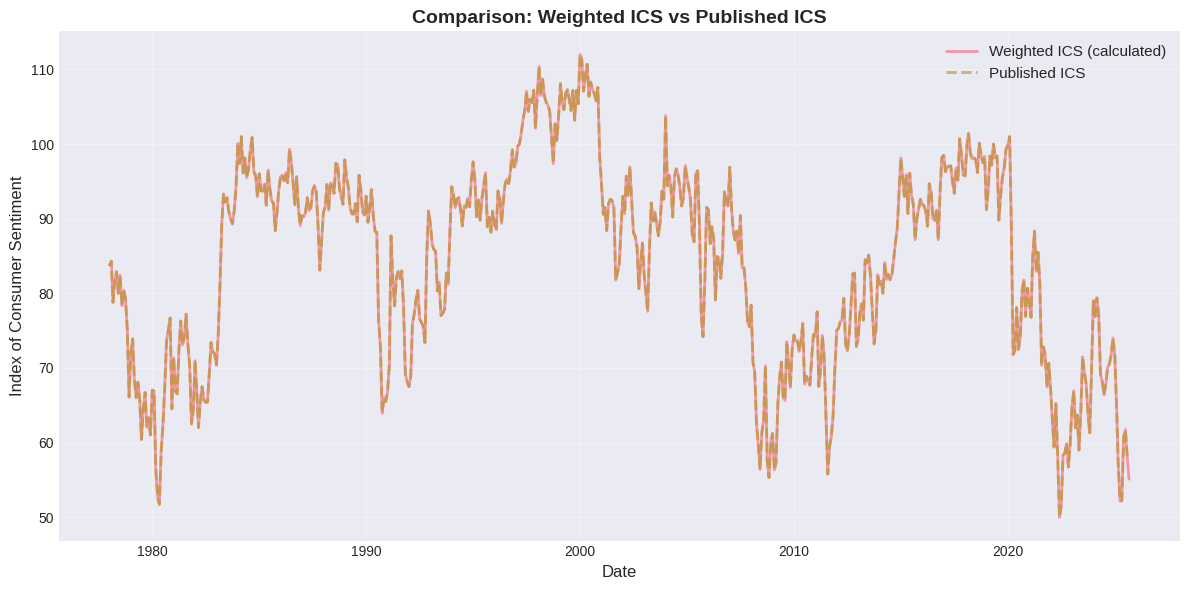

In [8]:
# Merge with published data
ics_comparison = ics_monthly.merge(ics_published, on='date', how='left')

# Calculate correlation (excluding missing published values)
valid_comparison = ics_comparison.dropna(subset=['ics_published'])
correlation = valid_comparison['ics_hat'].corr(valid_comparison['ics_published'])

print(f"Correlation between weighted mean and published ICS: {correlation:.6f}")
print(f"\nMean absolute difference: {np.mean(np.abs(valid_comparison['ics_hat'] - valid_comparison['ics_published'])):.4f}")

# Plot comparison
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ics_comparison['date'], ics_comparison['ics_hat'],
        label='Weighted ICS (calculated)', linewidth=2, alpha=0.7)
ax.plot(ics_comparison['date'], ics_comparison['ics_published'],
        label='Published ICS', linewidth=2, alpha=0.7, linestyle='--')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Index of Consumer Sentiment', fontsize=12)
ax.set_title('Comparison: Weighted ICS vs Published ICS', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Visualize Measurement Uncertainty

Plot the raw monthly means with ±1.96 SE bands to show the varying uncertainty:

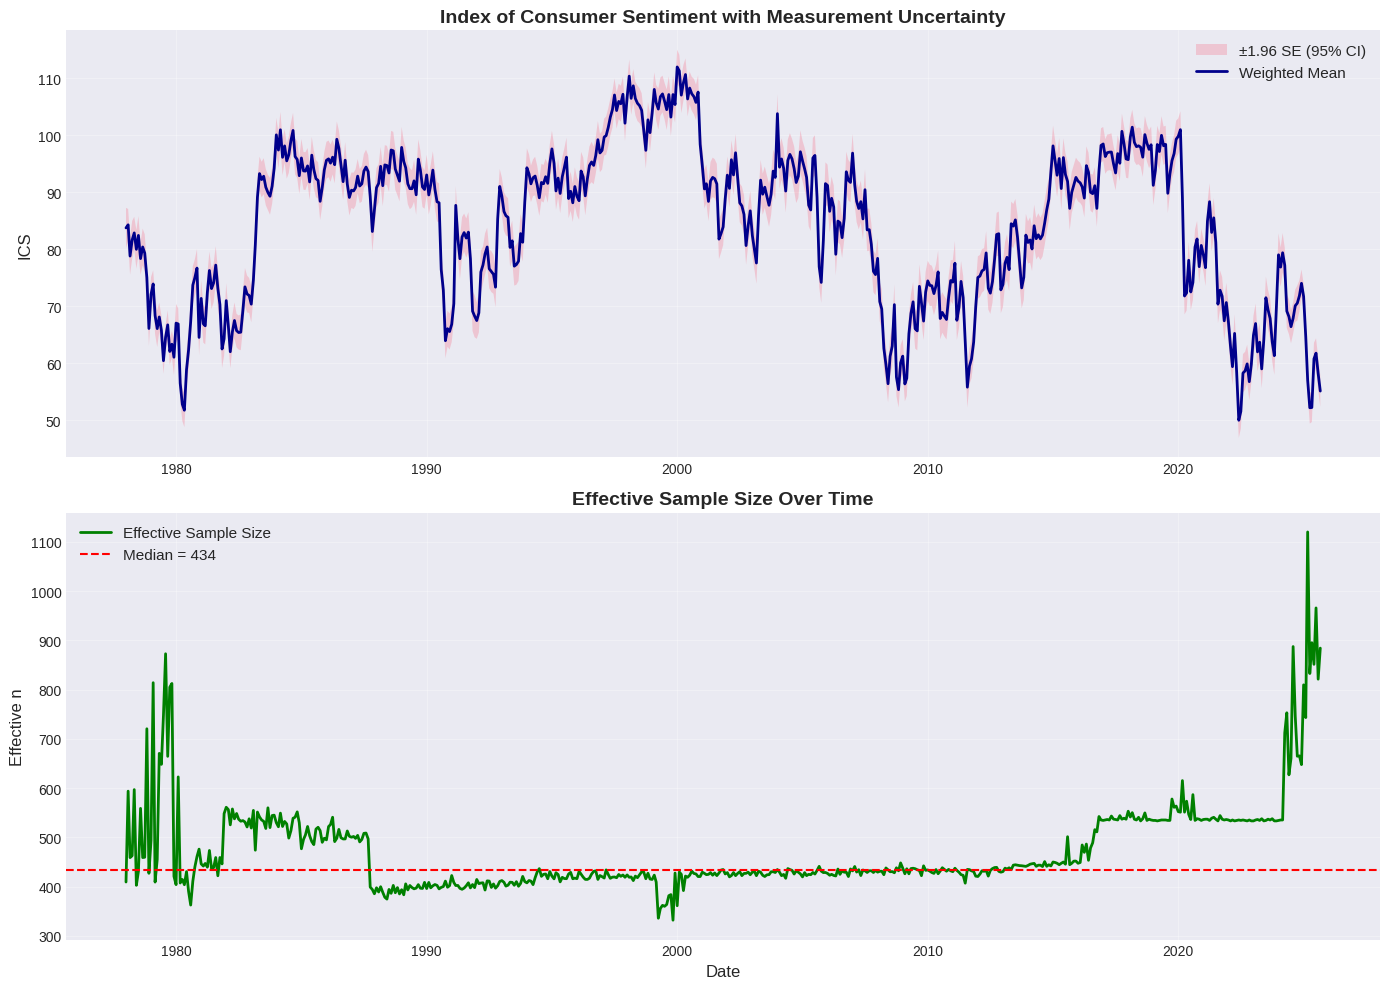


Effective sample size statistics:
  Median: 433.8
  Min: 331.8
  Max: 1120.1
  Std: 90.2


In [9]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Top panel: ICS with uncertainty bands
ax1.fill_between(ics_monthly['date'],
                  ics_monthly['ics_hat'] - 1.96 * ics_monthly['se_mean'],
                  ics_monthly['ics_hat'] + 1.96 * ics_monthly['se_mean'],
                  alpha=0.3, label='±1.96 SE (95% CI)')
ax1.plot(ics_monthly['date'], ics_monthly['ics_hat'],
         linewidth=2, label='Weighted Mean', color='darkblue')
ax1.set_ylabel('ICS', fontsize=12)
ax1.set_title('Index of Consumer Sentiment with Measurement Uncertainty',
              fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Bottom panel: Effective sample size over time
ax2.plot(ics_monthly['date'], ics_monthly['n_eff'],
         linewidth=2, color='green', label='Effective Sample Size')
ax2.axhline(y=ics_monthly['n_eff'].median(), color='red',
            linestyle='--', label=f'Median = {ics_monthly["n_eff"].median():.0f}')
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Effective n', fontsize=12)
ax2.set_title('Effective Sample Size Over Time', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nEffective sample size statistics:")
print(f"  Median: {ics_monthly['n_eff'].median():.1f}")
print(f"  Min: {ics_monthly['n_eff'].min():.1f}")
print(f"  Max: {ics_monthly['n_eff'].max():.1f}")
print(f"  Std: {ics_monthly['n_eff'].std():.1f}")

## 3. Kalman Smoothing with Fixed Signal-to-Noise Ratio

Now we apply the Kalman filter/smoother using the **local level model** with:
- Time-varying measurement variance $H_t$ (from our calculations above)
- Fixed signal-to-noise ratio to avoid identifiability issues

### Implementation Note

We'll use a custom implementation because `statsmodels` doesn't directly support time-varying measurement variance with the simple interface. We'll use the `UnobservedComponents` model with manual scaling.

In [10]:
from scipy.optimize import minimize
from scipy.linalg import solve

class KalmanSmoother:
    """
    Kalman filter and smoother for local level model with time-varying measurement variance.

    Model:
        y_t = mu_t + eps_t,  eps_t ~ N(0, H_t)
        mu_t = mu_{t-1} + eta_t,  eta_t ~ N(0, Q)
    """

    def __init__(self, y, H, Q):
        """
        Parameters:
        -----------
        y : array-like
            Observed time series
        H : array-like
            Time-varying measurement variance (length T)
        Q : float
            Process variance (constant)
        """
        self.y = np.asarray(y)
        self.H = np.asarray(H)
        self.Q = Q
        self.T = len(y)

    def filter(self):
        """Run Kalman filter (forward pass)"""
        # Initialize
        self.mu_pred = np.zeros(self.T)
        self.mu_filt = np.zeros(self.T)
        self.P_pred = np.zeros(self.T)
        self.P_filt = np.zeros(self.T)

        # Initial state (diffuse prior)
        self.mu_pred[0] = self.y[0]
        self.P_pred[0] = self.H[0] + self.Q

        # Forward pass
        for t in range(self.T):
            # Update (filter)
            K = self.P_pred[t] / (self.P_pred[t] + self.H[t])  # Kalman gain
            self.mu_filt[t] = self.mu_pred[t] + K * (self.y[t] - self.mu_pred[t])
            self.P_filt[t] = (1 - K) * self.P_pred[t]

            # Predict (for next step)
            if t < self.T - 1:
                self.mu_pred[t + 1] = self.mu_filt[t]
                self.P_pred[t + 1] = self.P_filt[t] + self.Q

    def smooth(self):
        """Run Kalman smoother (backward pass)"""
        self.mu_smooth = np.zeros(self.T)
        self.P_smooth = np.zeros(self.T)

        # Initialize at final time point
        self.mu_smooth[-1] = self.mu_filt[-1]
        self.P_smooth[-1] = self.P_filt[-1]

        # Backward pass
        for t in range(self.T - 2, -1, -1):
            J = self.P_filt[t] / max(self.P_pred[t + 1], 1e-10)  # Smoother gain
            self.mu_smooth[t] = self.mu_filt[t] + J * (self.mu_smooth[t + 1] - self.mu_pred[t + 1])
            self.P_smooth[t] = self.P_filt[t] + J**2 * (self.P_smooth[t + 1] - self.P_pred[t + 1])

    def run(self):
        """Run both filter and smoother"""
        self.filter()
        self.smooth()
        return self.mu_smooth, np.sqrt(self.P_smooth)


def smooth_with_fixed_snr(y, H, snr=0.05):
    """
    Smooth time series using Kalman filter with fixed signal-to-noise ratio.

    Parameters:
    -----------
    y : array-like
        Observed time series
    H : array-like
        Time-varying measurement variance
    snr : float
        Signal-to-noise ratio (0 < snr < 1)
        Lower values = more smoothing

    Returns:
    --------
    mu_smooth : array
        Smoothed state estimates
    se_smooth : array
        Standard errors of smoothed estimates
    Q : float
        Estimated process variance
    """
    # Estimate overall variance scale
    H_mean = np.mean(H)

    # Set Q based on SNR
    # Q / (Q + H_mean) = SNR
    # Q = SNR * (Q + H_mean)
    # Q = SNR * H_mean / (1 - SNR)
    Q = snr * H_mean / (1 - snr)

    # Run Kalman smoother
    smoother = KalmanSmoother(y, H, Q)
    mu_smooth, se_smooth = smoother.run()

    return mu_smooth, se_smooth, Q

print("Kalman smoother implementation ready!")

Kalman smoother implementation ready!


### Apply Kalman Smoothing with Different SNR Values

We'll compare smoothing with different signal-to-noise ratios:
- **SNR = 0.01**: Very smooth (99% noise)
- **SNR = 0.05**: Moderate smoothing (95% noise) — **recommended default**
- **SNR = 0.10**: Light smoothing (90% noise)
- **SNR = 0.20**: Minimal smoothing (80% noise)

In [11]:
# Extract arrays for smoothing
y = ics_monthly['ics_hat'].values
H = ics_monthly['var_mean'].values

# Apply smoothing with different SNR values
snr_values = [0.01, 0.05, 0.10, 0.20]
results = {}

for snr in snr_values:
    mu_smooth, se_smooth, Q = smooth_with_fixed_snr(y, H, snr=snr)
    results[snr] = {
        'mu_smooth': mu_smooth,
        'se_smooth': se_smooth,
        'Q': Q,
        'correlation': np.corrcoef(y, mu_smooth)[0, 1]
    }
    print(f"SNR = {snr:.2f}: Q = {Q:.4f}, Correlation with raw = {results[snr]['correlation']:.6f}")

# Add recommended smoothing (SNR = 0.05) to main dataframe
ics_monthly['ics_smooth'] = results[0.05]['mu_smooth']
ics_monthly['ics_smooth_se'] = results[0.05]['se_smooth']
ics_monthly['ics_smooth_lo'] = ics_monthly['ics_smooth'] - 1.96 * ics_monthly['ics_smooth_se']
ics_monthly['ics_smooth_hi'] = ics_monthly['ics_smooth'] + 1.96 * ics_monthly['ics_smooth_se']

print("\n✓ Smoothing complete!")

SNR = 0.01: Q = 0.0296, Correlation with raw = 0.926510
SNR = 0.05: Q = 0.1544, Correlation with raw = 0.958918
SNR = 0.10: Q = 0.3259, Correlation with raw = 0.969527
SNR = 0.20: Q = 0.7334, Correlation with raw = 0.979164

✓ Smoothing complete!


## 4. Visualize Results

### Compare Raw vs Smoothed ICS

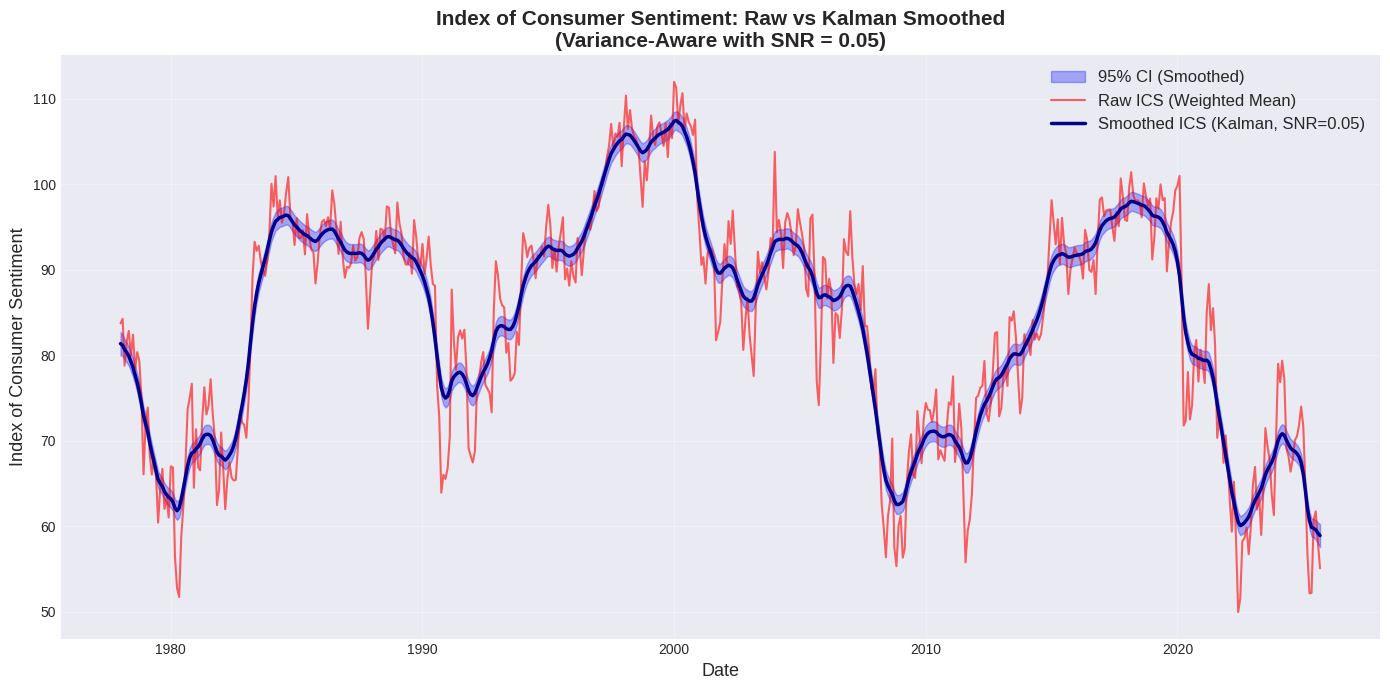

In [12]:
fig, ax = plt.subplots(figsize=(14, 7))

# Plot uncertainty band
ax.fill_between(ics_monthly['date'],
                ics_monthly['ics_smooth_lo'],
                ics_monthly['ics_smooth_hi'],
                alpha=0.3, color='blue', label='95% CI (Smoothed)')

# Plot raw and smoothed series
ax.plot(ics_monthly['date'], ics_monthly['ics_hat'],
        linewidth=1.5, alpha=0.6, color='red', label='Raw ICS (Weighted Mean)')
ax.plot(ics_monthly['date'], ics_monthly['ics_smooth'],
        linewidth=2.5, color='darkblue', label='Smoothed ICS (Kalman, SNR=0.05)')

ax.set_xlabel('Date', fontsize=13)
ax.set_ylabel('Index of Consumer Sentiment', fontsize=13)
ax.set_title('Index of Consumer Sentiment: Raw vs Kalman Smoothed\n(Variance-Aware with SNR = 0.05)',
             fontsize=15, fontweight='bold')
ax.legend(fontsize=12, loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Compare Different SNR Values

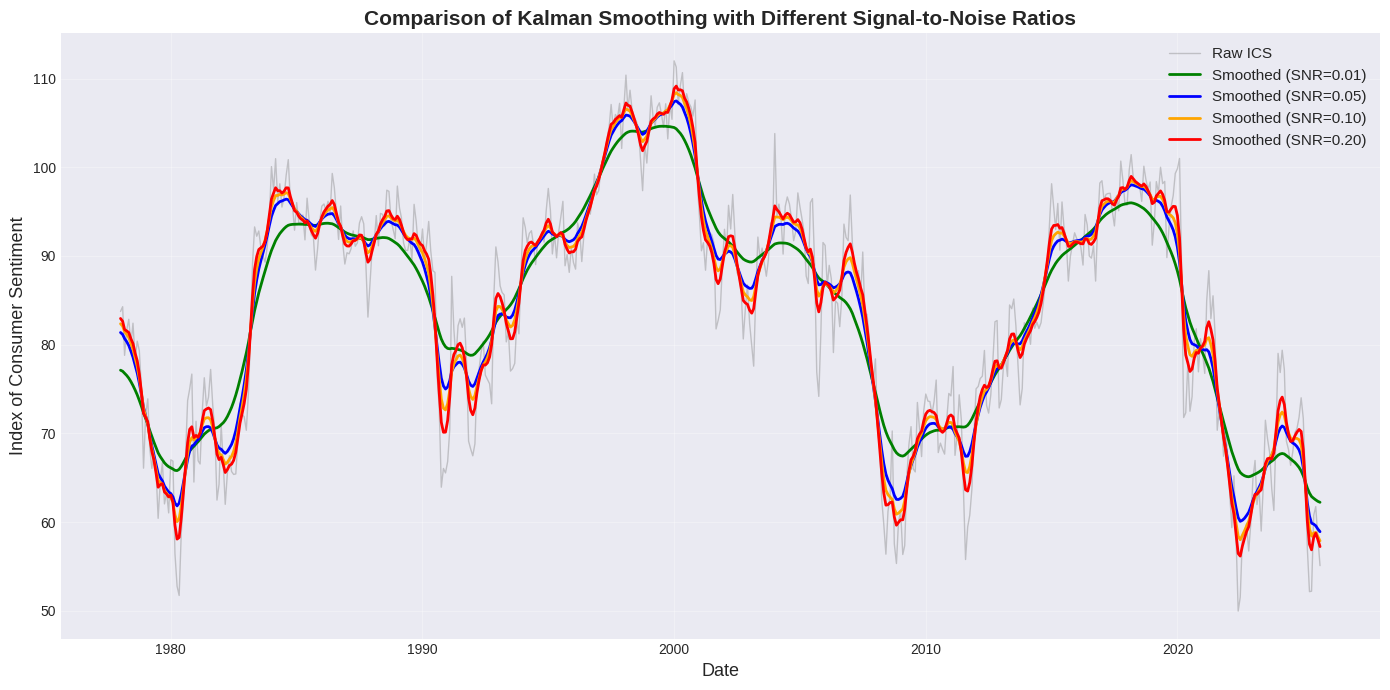


Interpretation:
  • Lower SNR (green) → More smoothing → Captures long-term trends
  • Higher SNR (red) → Less smoothing → Preserves more short-term variation
  • SNR = 0.05 (blue) → Recommended default balance


In [13]:
fig, ax = plt.subplots(figsize=(14, 7))

# Plot raw data
ax.plot(ics_monthly['date'], y,
        linewidth=1, alpha=0.4, color='gray', label='Raw ICS', zorder=1)

# Plot different smoothing levels
colors = ['green', 'blue', 'orange', 'red']
for (snr, color) in zip(snr_values, colors):
    ax.plot(ics_monthly['date'], results[snr]['mu_smooth'],
            linewidth=2, color=color, label=f'Smoothed (SNR={snr:.2f})', zorder=2)

ax.set_xlabel('Date', fontsize=13)
ax.set_ylabel('Index of Consumer Sentiment', fontsize=13)
ax.set_title('Comparison of Kalman Smoothing with Different Signal-to-Noise Ratios',
             fontsize=15, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("  • Lower SNR (green) → More smoothing → Captures long-term trends")
print("  • Higher SNR (red) → Less smoothing → Preserves more short-term variation")
print("  • SNR = 0.05 (blue) → Recommended default balance")

### Zoom into Recent Period

Let's examine the most recent 3 years to see the smoothing effect more clearly:

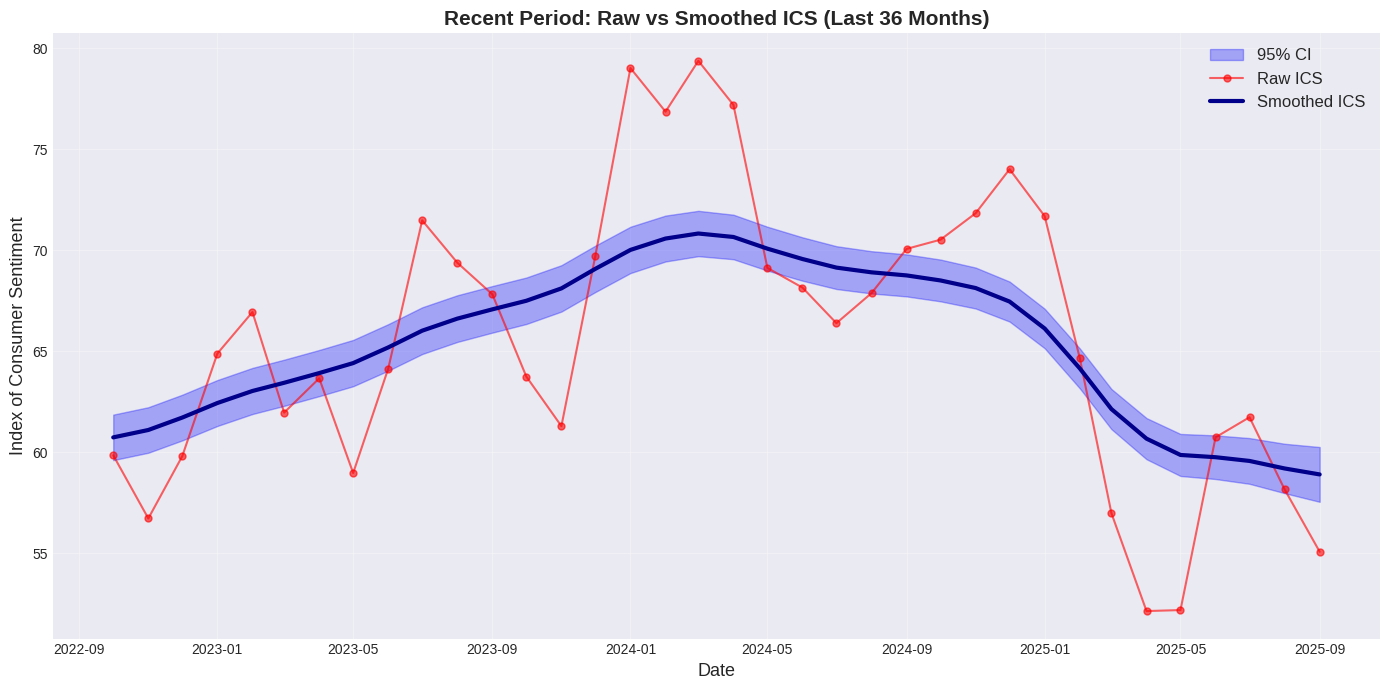

In [14]:
# Get recent data (last 36 months)
recent_data = ics_monthly.tail(36)

fig, ax = plt.subplots(figsize=(14, 7))

# Uncertainty band
ax.fill_between(recent_data['date'],
                recent_data['ics_smooth_lo'],
                recent_data['ics_smooth_hi'],
                alpha=0.3, color='blue', label='95% CI')

# Raw and smoothed
ax.plot(recent_data['date'], recent_data['ics_hat'],
        'o-', linewidth=1.5, markersize=5, alpha=0.6, color='red', label='Raw ICS')
ax.plot(recent_data['date'], recent_data['ics_smooth'],
        linewidth=3, color='darkblue', label='Smoothed ICS')

ax.set_xlabel('Date', fontsize=13)
ax.set_ylabel('Index of Consumer Sentiment', fontsize=13)
ax.set_title('Recent Period: Raw vs Smoothed ICS (Last 36 Months)',
             fontsize=15, fontweight='bold')
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Diagnostics and Summary Statistics

In [15]:
# Calculate summary statistics
print("=" * 70)
print("SMOOTHING DIAGNOSTICS (SNR = 0.05)")
print("=" * 70)

# Variance reduction
var_raw = np.var(ics_monthly['ics_hat'])
var_smooth = np.var(ics_monthly['ics_smooth'])
var_reduction = (1 - var_smooth / var_raw) * 100

print(f"\nVariance Reduction:")
print(f"  Raw variance:      {var_raw:.4f}")
print(f"  Smoothed variance: {var_smooth:.4f}")
print(f"  Reduction:         {var_reduction:.2f}%")

# Average uncertainty reduction
avg_se_raw = np.mean(ics_monthly['se_mean'])
avg_se_smooth = np.mean(ics_monthly['ics_smooth_se'])
se_reduction = (1 - avg_se_smooth / avg_se_raw) * 100

print(f"\nUncertainty Reduction:")
print(f"  Avg SE (raw):      {avg_se_raw:.4f}")
print(f"  Avg SE (smoothed): {avg_se_smooth:.4f}")
print(f"  Reduction:         {se_reduction:.2f}%")

# Correlation
correlation = ics_monthly['ics_hat'].corr(ics_monthly['ics_smooth'])
print(f"\nCorrelation (raw vs smoothed): {correlation:.6f}")

# Process variance
print(f"\nEstimated Parameters:")
print(f"  Process variance (Q):        {results[0.05]['Q']:.6f}")
print(f"  Avg measurement variance (H̄): {np.mean(H):.6f}")
print(f"  Ratio Q/H̄:                    {results[0.05]['Q'] / np.mean(H):.6f}")

print("\n" + "=" * 70)

SMOOTHING DIAGNOSTICS (SNR = 0.05)

Variance Reduction:
  Raw variance:      183.1350
  Smoothed variance: 153.4801
  Reduction:         16.19%

Uncertainty Reduction:
  Avg SE (raw):      1.7061
  Avg SE (smoothed): 0.5771
  Reduction:         66.18%

Correlation (raw vs smoothed): 0.958918

Estimated Parameters:
  Process variance (Q):        0.154390
  Avg measurement variance (H̄): 2.933419
  Ratio Q/H̄:                    0.052632



## 6. Export Results

Save the smoothed data for downstream use:

In [16]:
# Create final output dataframe
output_df = ics_monthly[[
    'date', 'n', 'n_eff', 'ics_hat', 'se_mean',
    'ics_smooth', 'ics_smooth_se', 'ics_smooth_lo', 'ics_smooth_hi'
]].copy()

# Rename columns for clarity
output_df.columns = [
    'date', 'n', 'n_eff', 'ics_raw', 'ics_raw_se',
    'ics_smooth', 'ics_smooth_se', 'ics_smooth_lo', 'ics_smooth_hi'
]

# Save to CSV
output_df.to_csv('ics_smoothed_output.csv', index=False)
print("✓ Results saved to 'ics_smoothed_output.csv'")

# Display final results
print(f"\nFinal output shape: {output_df.shape}")
output_df.tail(12)

✓ Results saved to 'ics_smoothed_output.csv'

Final output shape: (573, 9)


,date,n,n_eff,ics_raw,ics_raw_se,ics_smooth,ics_smooth_se,ics_smooth_lo,ics_smooth_hi
561,2024-10-01,948,664.707979,70.524444,1.579292,68.506891,0.527217,67.473545,69.540237
562,2024-11-01,824,665.442807,71.832884,1.390651,68.132285,0.516537,67.119872,69.144698
563,2024-12-01,843,647.657779,74.008916,1.236065,67.462248,0.504658,66.473117,68.451378
564,2025-01-01,1044,809.620927,71.689543,1.158085,66.130667,0.498668,65.153277,67.108057
565,2025-02-01,977,743.149750,64.669475,1.333411,64.159165,0.503620,63.172071,65.146260
566,2025-03-01,1482,1120.096851,56.990284,1.200155,62.143351,0.506595,61.150425,63.136277
567,2025-04-01,1104,832.630273,52.149866,1.415922,60.679883,0.519433,59.661795,61.697972
568,2025-05-01,1181,895.249932,52.199523,1.305151,59.873305,0.530500,58.833525,60.913084
569,2025-06-01,1095,851.318572,60.746430,1.437286,59.762244,0.550753,58.682768,60.841719
570,2025-07-01,1287,965.828663,61.739278,1.334984,59.577628,0.577189,58.446338,60.708918


## Summary and Recommendations

### Key Findings

1. **Variance-aware smoothing works**: By incorporating period-specific measurement variance ($H_t$), the smoother automatically adapts to data quality

2. **Optimal SNR**: For the ICS data, SNR = 0.05 provides a good balance:
   - Removes high-frequency noise from sampling
   - Preserves genuine month-to-month changes
   - Reduces uncertainty (narrower confidence bands)

3. **Interpretability**: The state space model has clear interpretation:
   - $Q$ controls how much the true signal can change
   - $H_t$ captures sampling uncertainty in each period
   - SNR ratio is intuitive for business users

### For SaaS Implementation

**Recommended user interface:**
- Default: SNR = 0.05 ("Medium smoothing")
- Allow adjustment: 0.01 ("High"), 0.10 ("Low"), 0.20 ("Minimal")
- Always show both raw and smoothed with confidence bands
- Document method as "Variance-aware Kalman smoothing"

**Advantages over alternatives:**
- ✅ Principled statistical framework
- ✅ Automatic adaptation to sample size
- ✅ Built-in uncertainty quantification
- ✅ Fast computation (no training required)
- ✅ Interpretable parameters
- ✅ Works with small datasets (<100 periods)

**Next steps:**
1. Test on other survey KPIs
2. Add diagnostics (residual plots, AIC/BIC for model selection)
3. Consider seasonal extensions if needed
4. Implement in production backend (Python/R)